# Wing Aerodynamics Analysis using Vortex-Step Method (VSM), Lift Line Theory (LLT), Vortex Lattice Method (VSM) and Computational Fluid Dynamics(CFD)
This notebook demonstrates the process of setting up and analyzing a wing's aerodynamics using VSM, LLT, VLM and CFD. We'll cover the following steps:
1. Setting up the environment and importing necessary libraries.
2. Process the data and store in processed_data
3. Run the solver, iteratively for multiple angles of attack
4. Store the results in results folder

## 1. Import necessary libraries
In this step, we import the necessary libraries for the aerodynamic analysis. We use:
- `numpy` for numerical operations.
- The `VSM` module for the aerodynamic modelling.
- The 'SurfplanAdapter' module to adapt SP files for the VSM module.

Make sure the `VSM` module is properly installed in your (virtual) environment, by running the cmd: `pip install -e .` from the root-directory of the `VSM` project.

Make sure the `SurfplanAdapter` module is properly installed in your (virtual) environment, by running the cmd: `pip install -e .` from the root-directory of the `SurfplanAdapter-main` project.

In [31]:
import os
import sys
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# %% Surfplan Adaptater
from SurfplanAdapter.surfplan_to_vsm.generate_vsm_input import (
    generate_VSM_input,
)
from SurfplanAdapter.logging_config import *

# %% VSM
from VSM.Solver import Solver
import VSM.plotting as plotting

# %% VLM
import aerosandbox as asb
import aerosandbox.numpy as np

# %% Surfplan Adaptater for VLM
# Get the absolute path of the the parent folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add this path to sys.path
sys.path.append(parent_dir)

from SurfplanAdapter_VLM_main.src.VLM.SPadapter_for_VLM import read_surfplan_txt_vlm


## 2. Process the data and store in processed_data

We create a `WingAerodynamics` object, from a `.txt` file, with the `generate_VSM_input` function through the following inputs : 
- `filepath` (str): the path to the kite 3D .txt extracted from Surfplan 
- `n_panels` (int): Number of panels to be used in the aerodynamic mesh
- `spanwise_panel_distribution` (str): Spanwise panel distribution type, sub-options:
    - `"linear"`: Linear distribution, even distribution
    - `"cosine"`: Cosine distribution, alots higher panel concetration near the tips and less mid-span
    - `"cosine_van_Garrel"`: Cosine distribution based on van Garrel method
    - `"split_provided"`: Keeps the original provided sections, and splits these evenly.
    - `"unchanged"`: Keep the original provided sections unchanged
- `is_save_geometry` (bool): choose to save or not the geometry in a .csv file
- `csv_file_path` (str): the file path where to save the .csv file

⚠ Here we choose the DELFT/BEYOND data through `kite_name` & `kite_origin` ⚠

### For `VSM` :

In [22]:
# Find the root directory of the repository
root_dir = os.path.abspath(os.getcwd())
while not os.path.isfile(os.path.join(root_dir, ".gitignore")):
    root_dir = os.path.abspath(os.path.join(root_dir, ".."))
    if root_dir == "/":
        raise FileNotFoundError("Could not find the root directory of the repository.")

# %% VSM 
# 1. Defining paths
# %% DELFT
kite_origin = "TUDELFT_V3_LEI_KITE"
kite_name = "V3D_3d_copy"
# # %% Beyond
# kite_origin = "BEYOND_THE_SEA"
# kite_name = "SK50-VH_3d"

filepath = Path(root_dir) / "data" / kite_origin / str(kite_name+".txt")

# 2. Transforming the data into VSM input format
n_panels = 30
spanwise_panel_distribution = "linear"
wing_aero = generate_VSM_input(
    filepath,
    n_panels=n_panels,
    spanwise_panel_distribution=spanwise_panel_distribution,
    is_save_geometry=True,
    csv_file_path=Path(root_dir)
    / "processed_data"
    / kite_origin
    / str(kite_name + "_geometry.csv"),
)

row:[array([-0.520832,  4.156287,  0.916618]), array([0.864107, 4.156287, 0.916618]), ['lei_airfoil_breukels', [np.float64(0.10335689875149735), 0.040334]]]
row:[array([-0.709238,  3.967978,  1.791356]), array([1.011852, 3.955506, 1.787553]), ['lei_airfoil_breukels', [np.float64(0.08805852729442161), 0.058051]]]
row:[array([-0.79088 ,  3.80535 ,  2.209568]), array([1.189372, 3.789238, 2.199439]), ['lei_airfoil_breukels', [np.float64(0.08183479490264242), 0.065676]]]
row:[array([-0.864219,  3.501223,  2.540205]), array([1.256822, 3.485499, 2.522089]), ['lei_airfoil_breukels', [np.float64(0.08053596122712194), 0.072045]]]
row:[array([-0.929298,  3.134335,  2.796493]), array([1.310901, 3.116753, 2.773988]), ['lei_airfoil_breukels', [np.float64(0.07956414448333324), 0.077435]]]
row:[array([-0.986158,  2.7983  ,  3.092998]), array([1.354755, 2.780285, 3.065722]), ['lei_airfoil_breukels', [np.float64(0.0788201065048211), 0.081992]]]
row:[array([-1.034831,  2.393198,  3.288677]), array([1.390

### For `VLM` :

In [34]:
# %% VLM 
airplane_vlm = read_surfplan_txt_vlm(filepath)
print(airplane_vlm.wings)

[Wing 'V3D_3d_copy' (24 xsecs, asymmetric)]


## 3. Run the solver, iteratively for multiple angles of attack

We set the `inflow conditions`, `plot` the wing, then solve the `aerodynamics`

### For `VSM` :

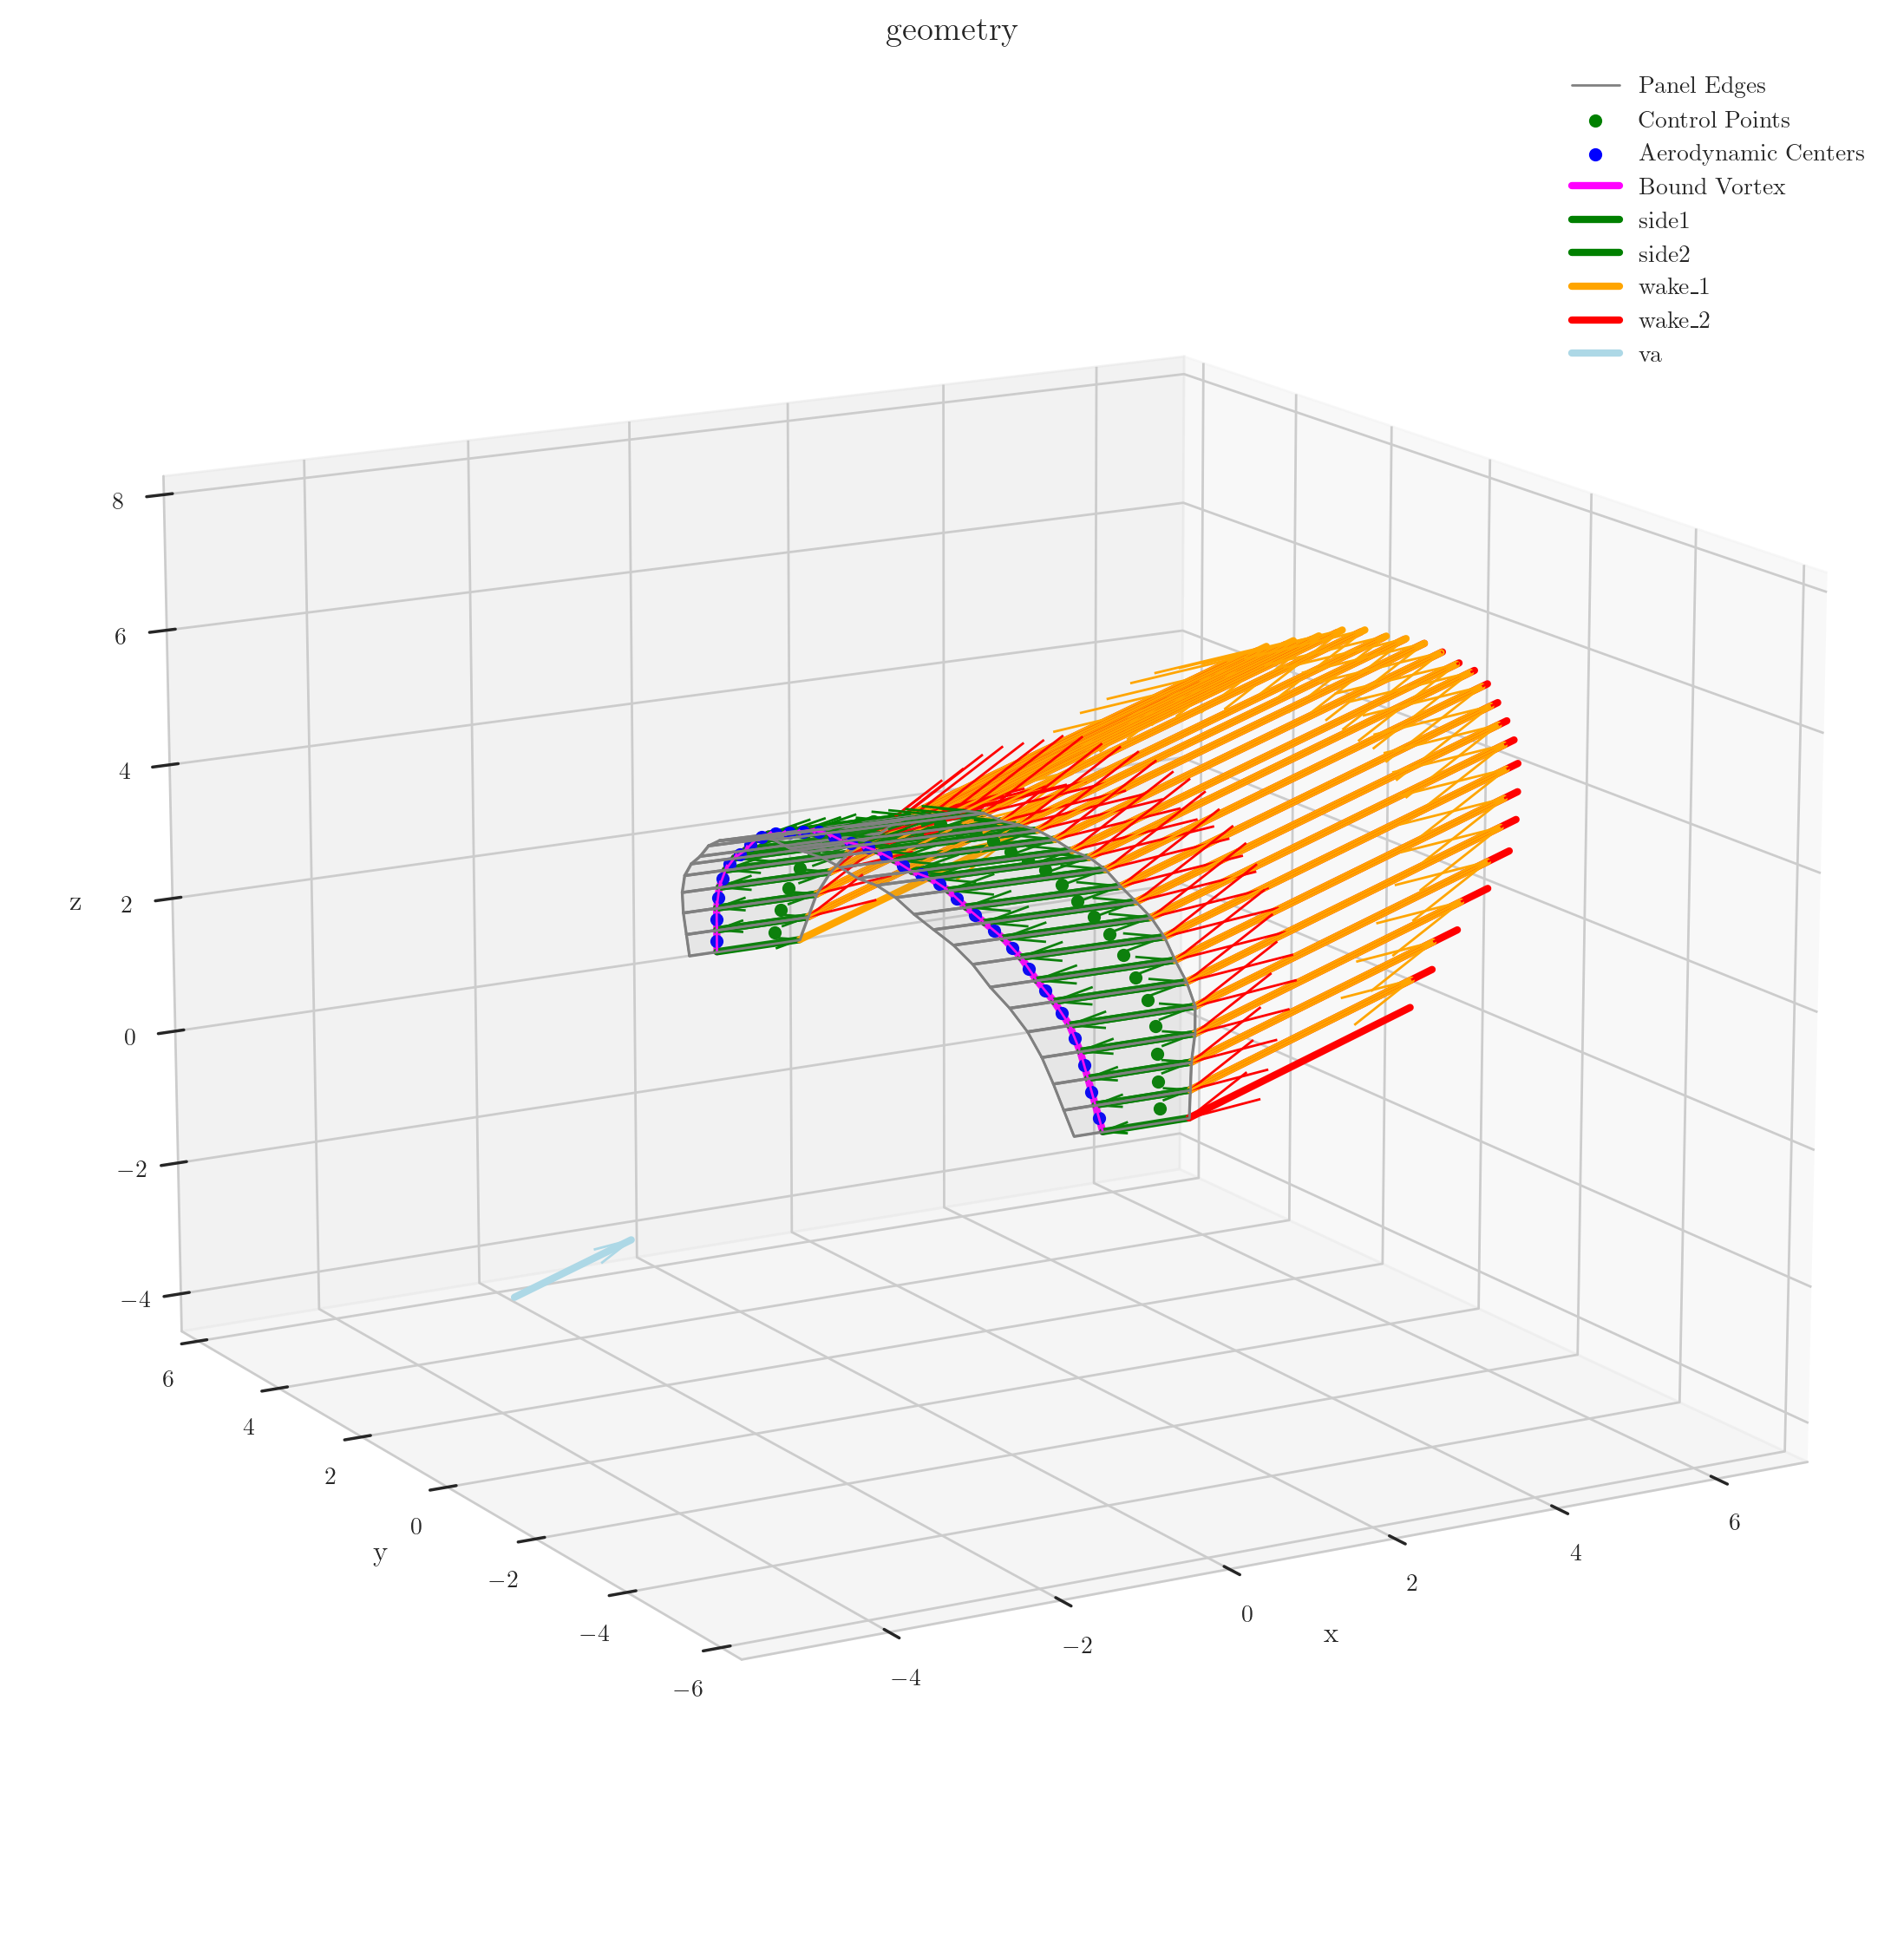

INFO:root:Converged after 676 iterations
INFO:root:Converged after 685 iterations


In [24]:
# Set the flow conditions
aoa = np.deg2rad(22)
angle_range_max = 25
sideslip = 0
Umag = 20
wing_aero.va = (
    np.array([np.cos(aoa) * np.cos(sideslip), np.sin(sideslip), np.sin(aoa)]) * Umag,
    0,
)
atmo = asb.Atmosphere(altitude=0)

# ### Plotting the wing
save_path = Path(root_dir) / "results" / kite_origin
plotting.plot_geometry(
    wing_aero,
    title="geometry",
    data_type=".pdf",
    save_path=save_path,
    is_save=True,
    is_show=True,
)

### Solve the aerodynamics
# cl,cd,cs coefficients are flipped to "normal ref frame"
# x (+) downstream, y(+) left and z-up reference frame
VSM = Solver(aerodynamic_model_type="VSM", is_with_artificial_damping=False,)
VSM_with_stall_correction = Solver(aerodynamic_model_type="VSM", is_with_artificial_damping=True,)
result_VSM = VSM.solve(wing_aero)
result_VSM_with_stall_correction = VSM_with_stall_correction.solve(wing_aero)

### For `VLM` :

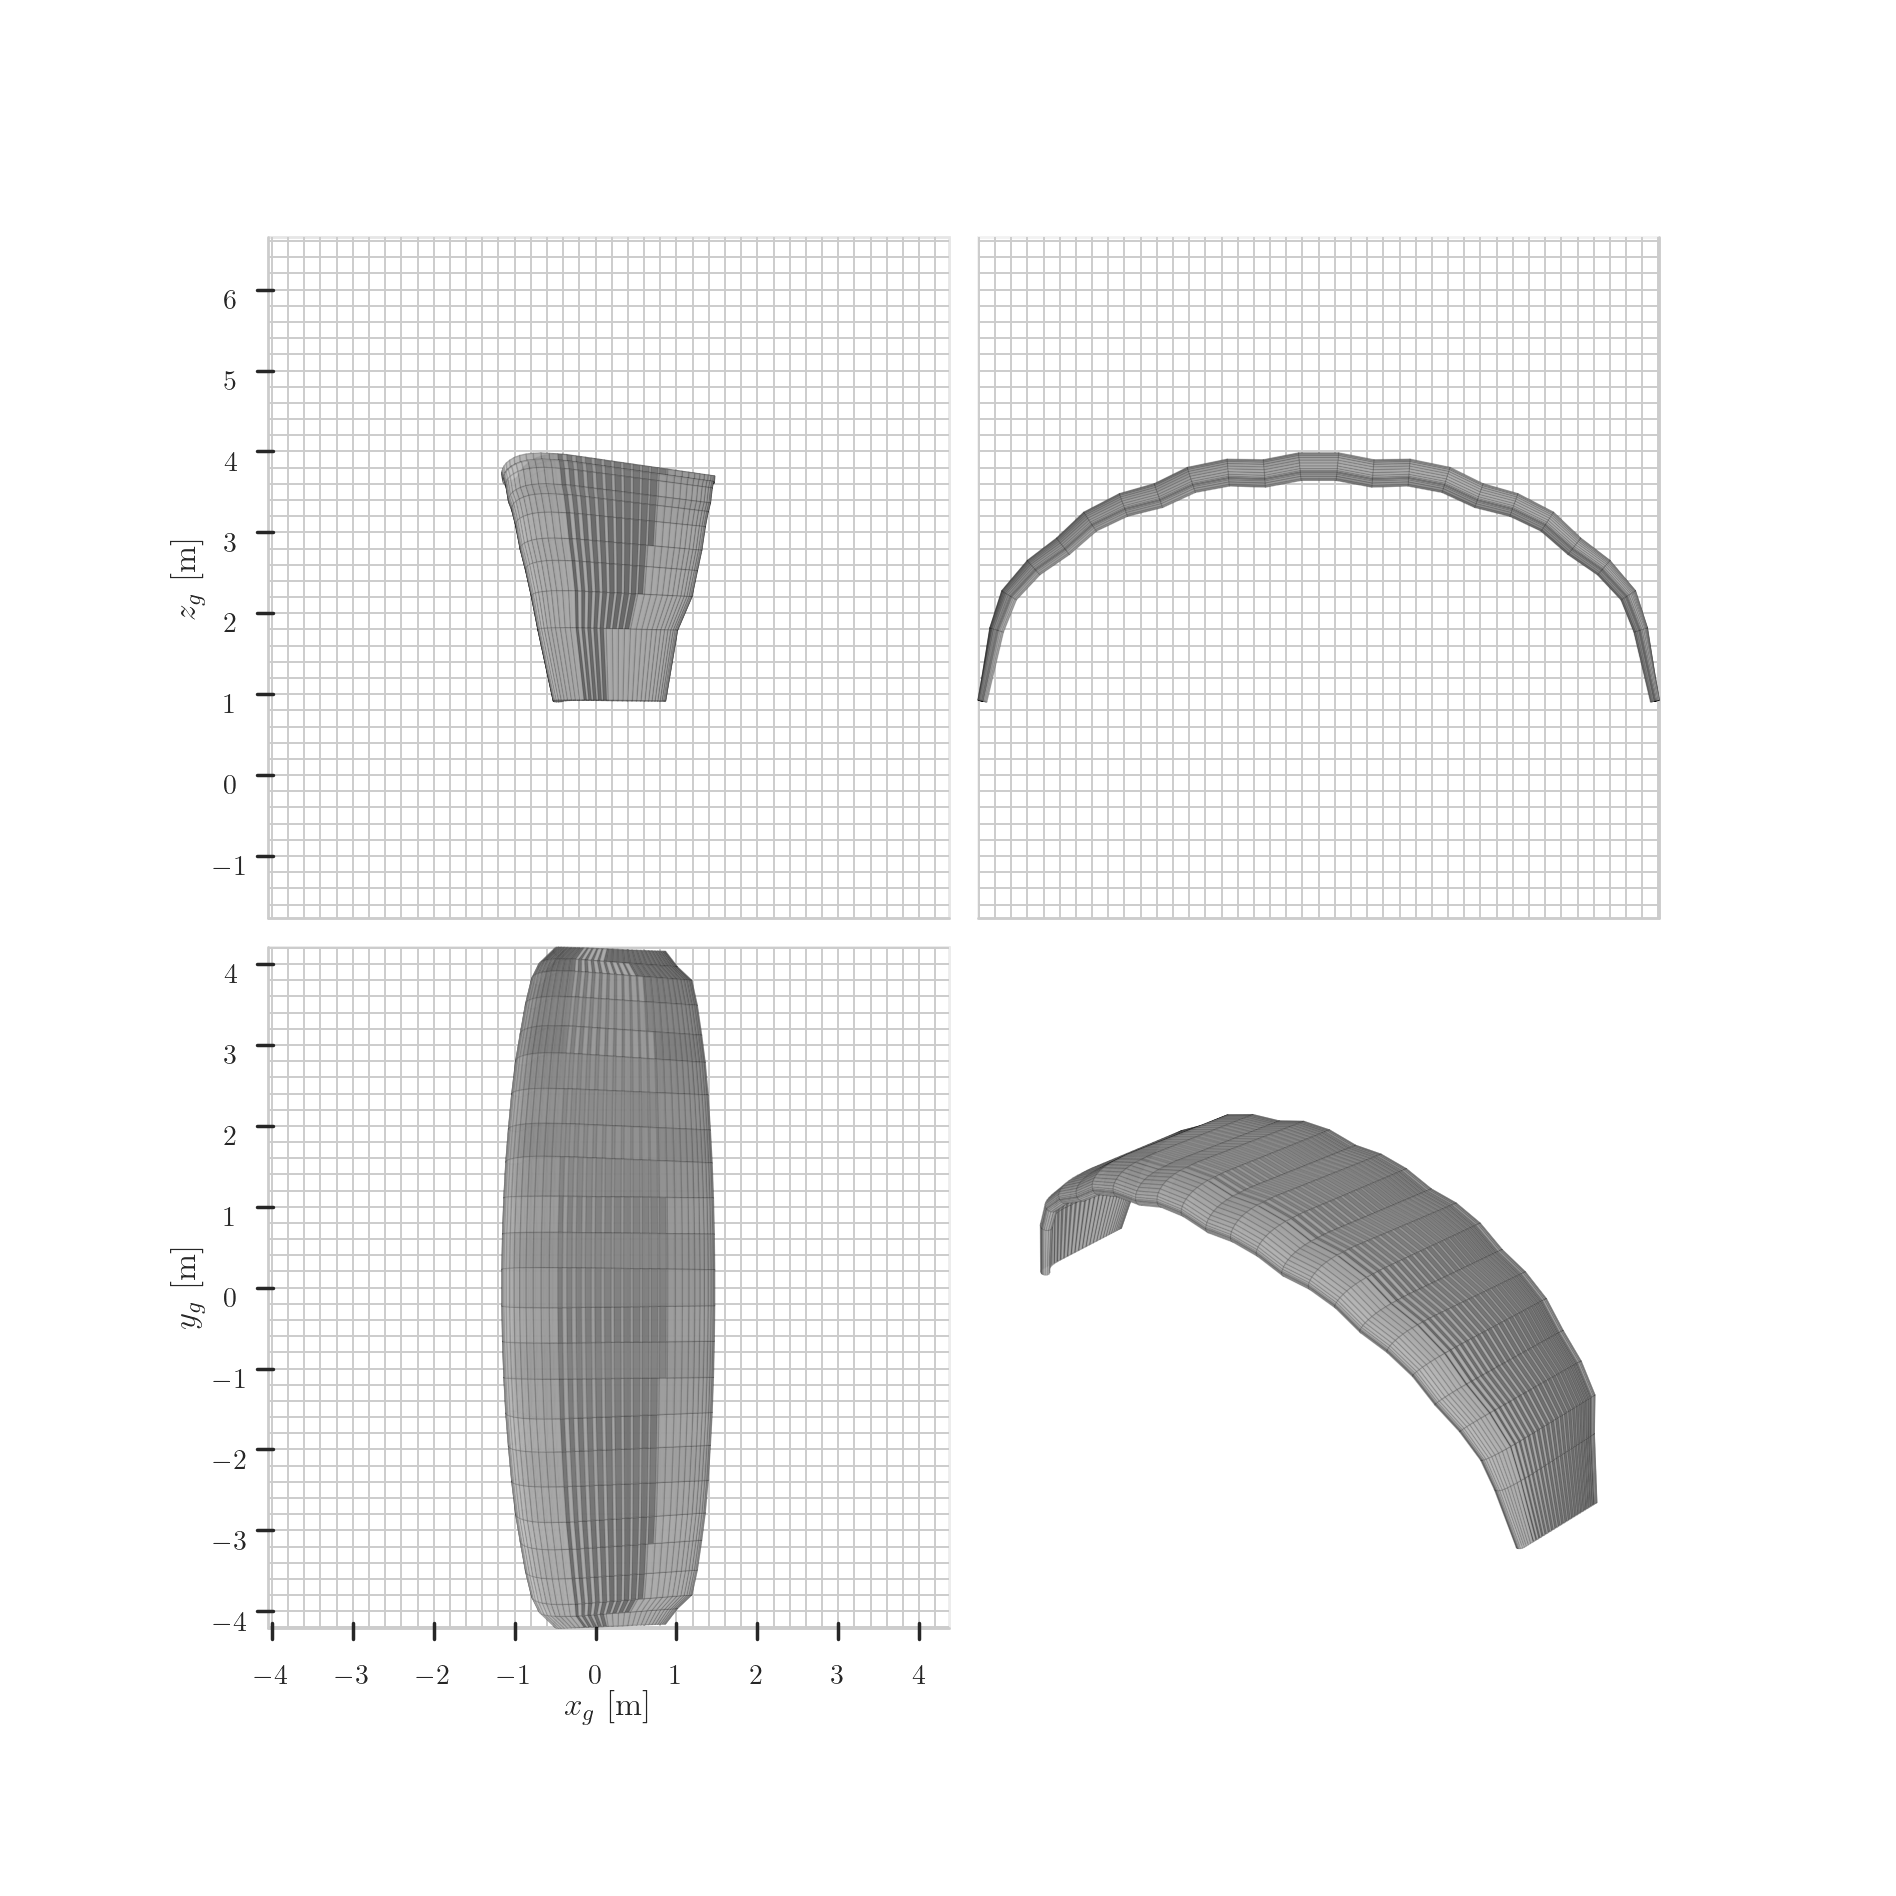

In [25]:
# %% VLM
# ### Plotting the wing
airplane_vlm.draw_three_view()
chordwise_resolution = 8

aerodynamic_center = airplane_vlm.aerodynamic_center()
dynamic_pressure = 0.5 * atmo.density() * Umag**2
Re = (
                atmo.density()
                * Umag
                * airplane_vlm.wings[0].mean_aerodynamic_chord()
                / atmo.dynamic_viscosity()
            )

vlm_result = []
for alpha in range(angle_range_max+1) :
    vlm = asb.VortexLatticeMethod(
        chordwise_resolution=chordwise_resolution,
        spanwise_resolution=1,
        spanwise_spacing_function=np.linspace,
        airplane=airplane_vlm,
        op_point=asb.OperatingPoint(
            velocity=Umag,  # m/s
            alpha=alpha,  # degree
        ),
    )

    vlm_result.append(vlm.run())

# %% Export data 
df = pd.json_normalize(vlm_result)
df["aoa"] = np.linspace(0, angle_range_max, angle_range_max+1)

vlm_csv_file = "vlm_"+kite_name+".csv"
vlm_name = "vlm_"+kite_name
path_vlm =(
    Path(root_dir)
    / "results"
    / kite_origin
    / "VLM"
    / vlm_csv_file
)
df_selected = df[['CL', 'CD', 'aoa']]
df_selected.to_csv(path_vlm, index=False)

## 4. Store the results in results folder

We `plot` the resulting `distributions` and `polars`

INFO:root:Error saving figure: [Errno 2] No such file or directory: 'c:\\Users\\RomainLambert\\BEYOND_THE_SEA\\SIMULATION\\results\\TUDELFT_V3_LEI_KITE\\spanwise_distributions for aoa 22.0 [deg], beta 0 [deg], yaw 0 [deg], Umag 20.0 m\\s.pdf'
INFO:root:Error type: FileNotFoundError
INFO:root:Error details: (<class 'FileNotFoundError'>, FileNotFoundError(2, 'No such file or directory'), <traceback object at 0x0000020A83828740>)
INFO:root:Converged after 448 iterations
INFO:root:Converged after 432 iterations
INFO:root:Converged after 426 iterations
INFO:root:Converged after 422 iterations
INFO:root:Converged after 419 iterations
INFO:root:Converged after 417 iterations
INFO:root:Converged after 415 iterations
INFO:root:Converged after 415 iterations
INFO:root:Converged after 416 iterations
INFO:root:Converged after 417 iterations
INFO:root:Converged after 419 iterations
INFO:root:Converged after 423 iterations
INFO:root:Converged after 427 iterations
INFO:root:Converged after 432 iterat

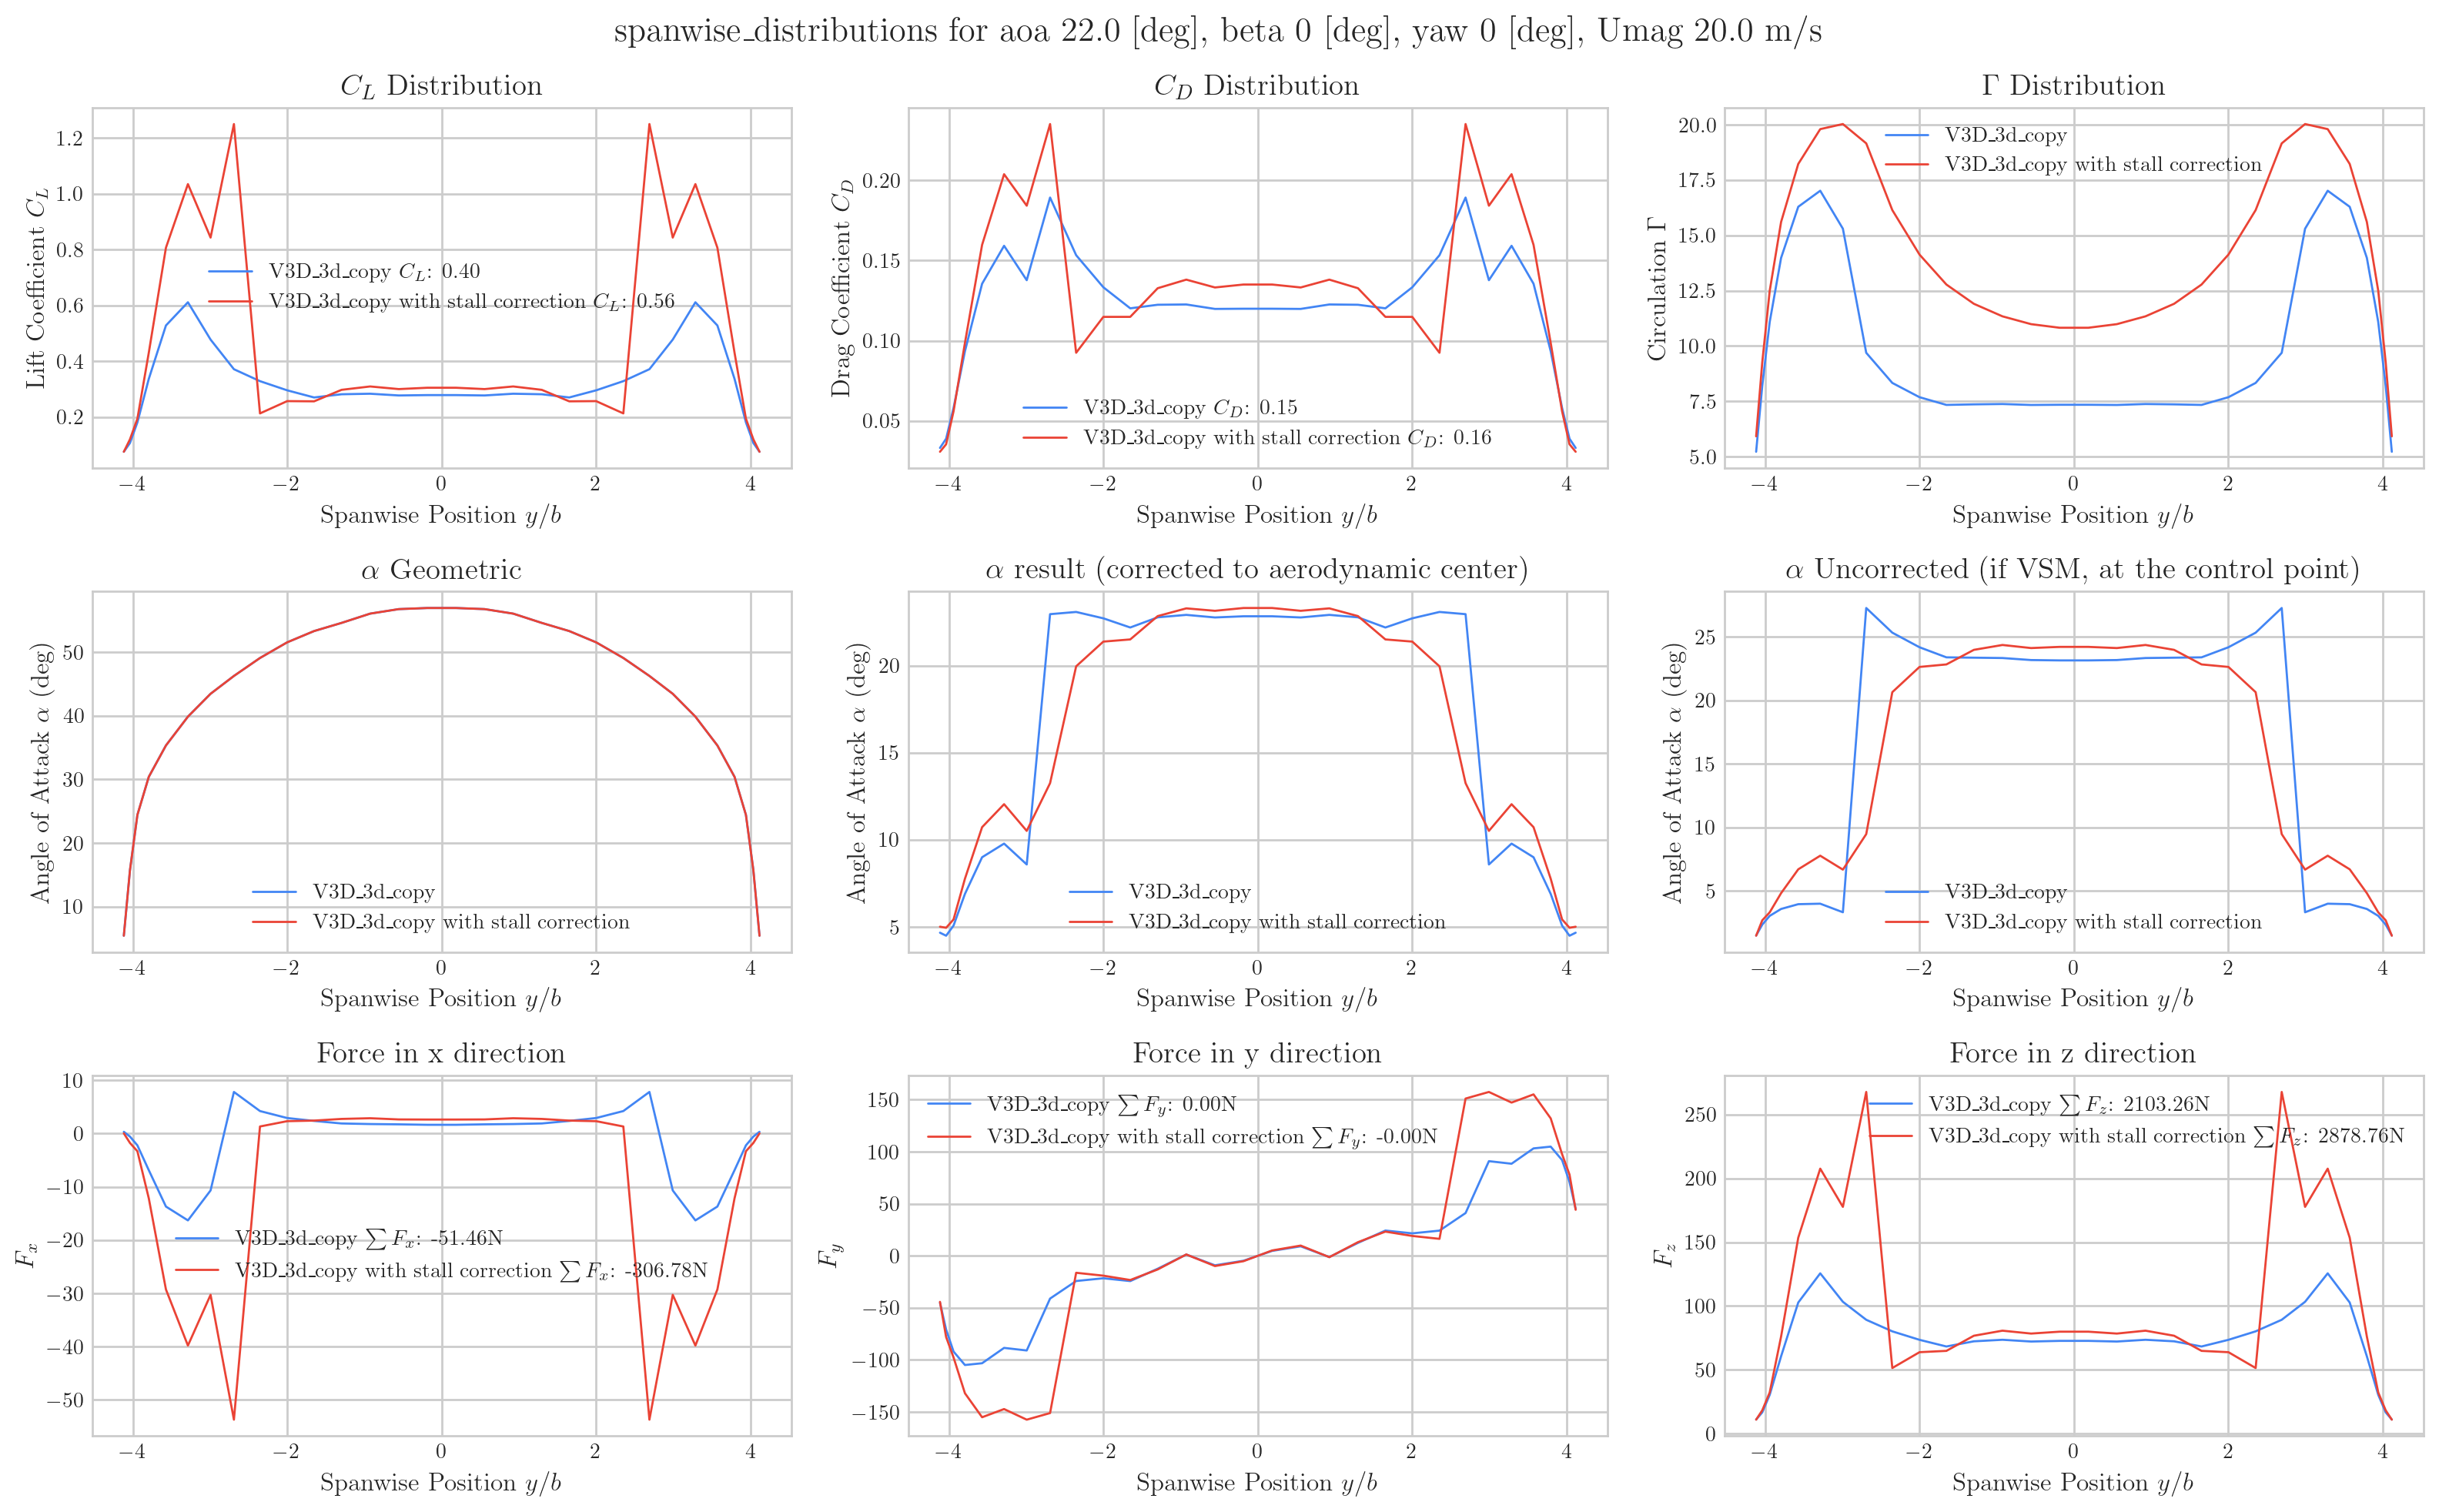

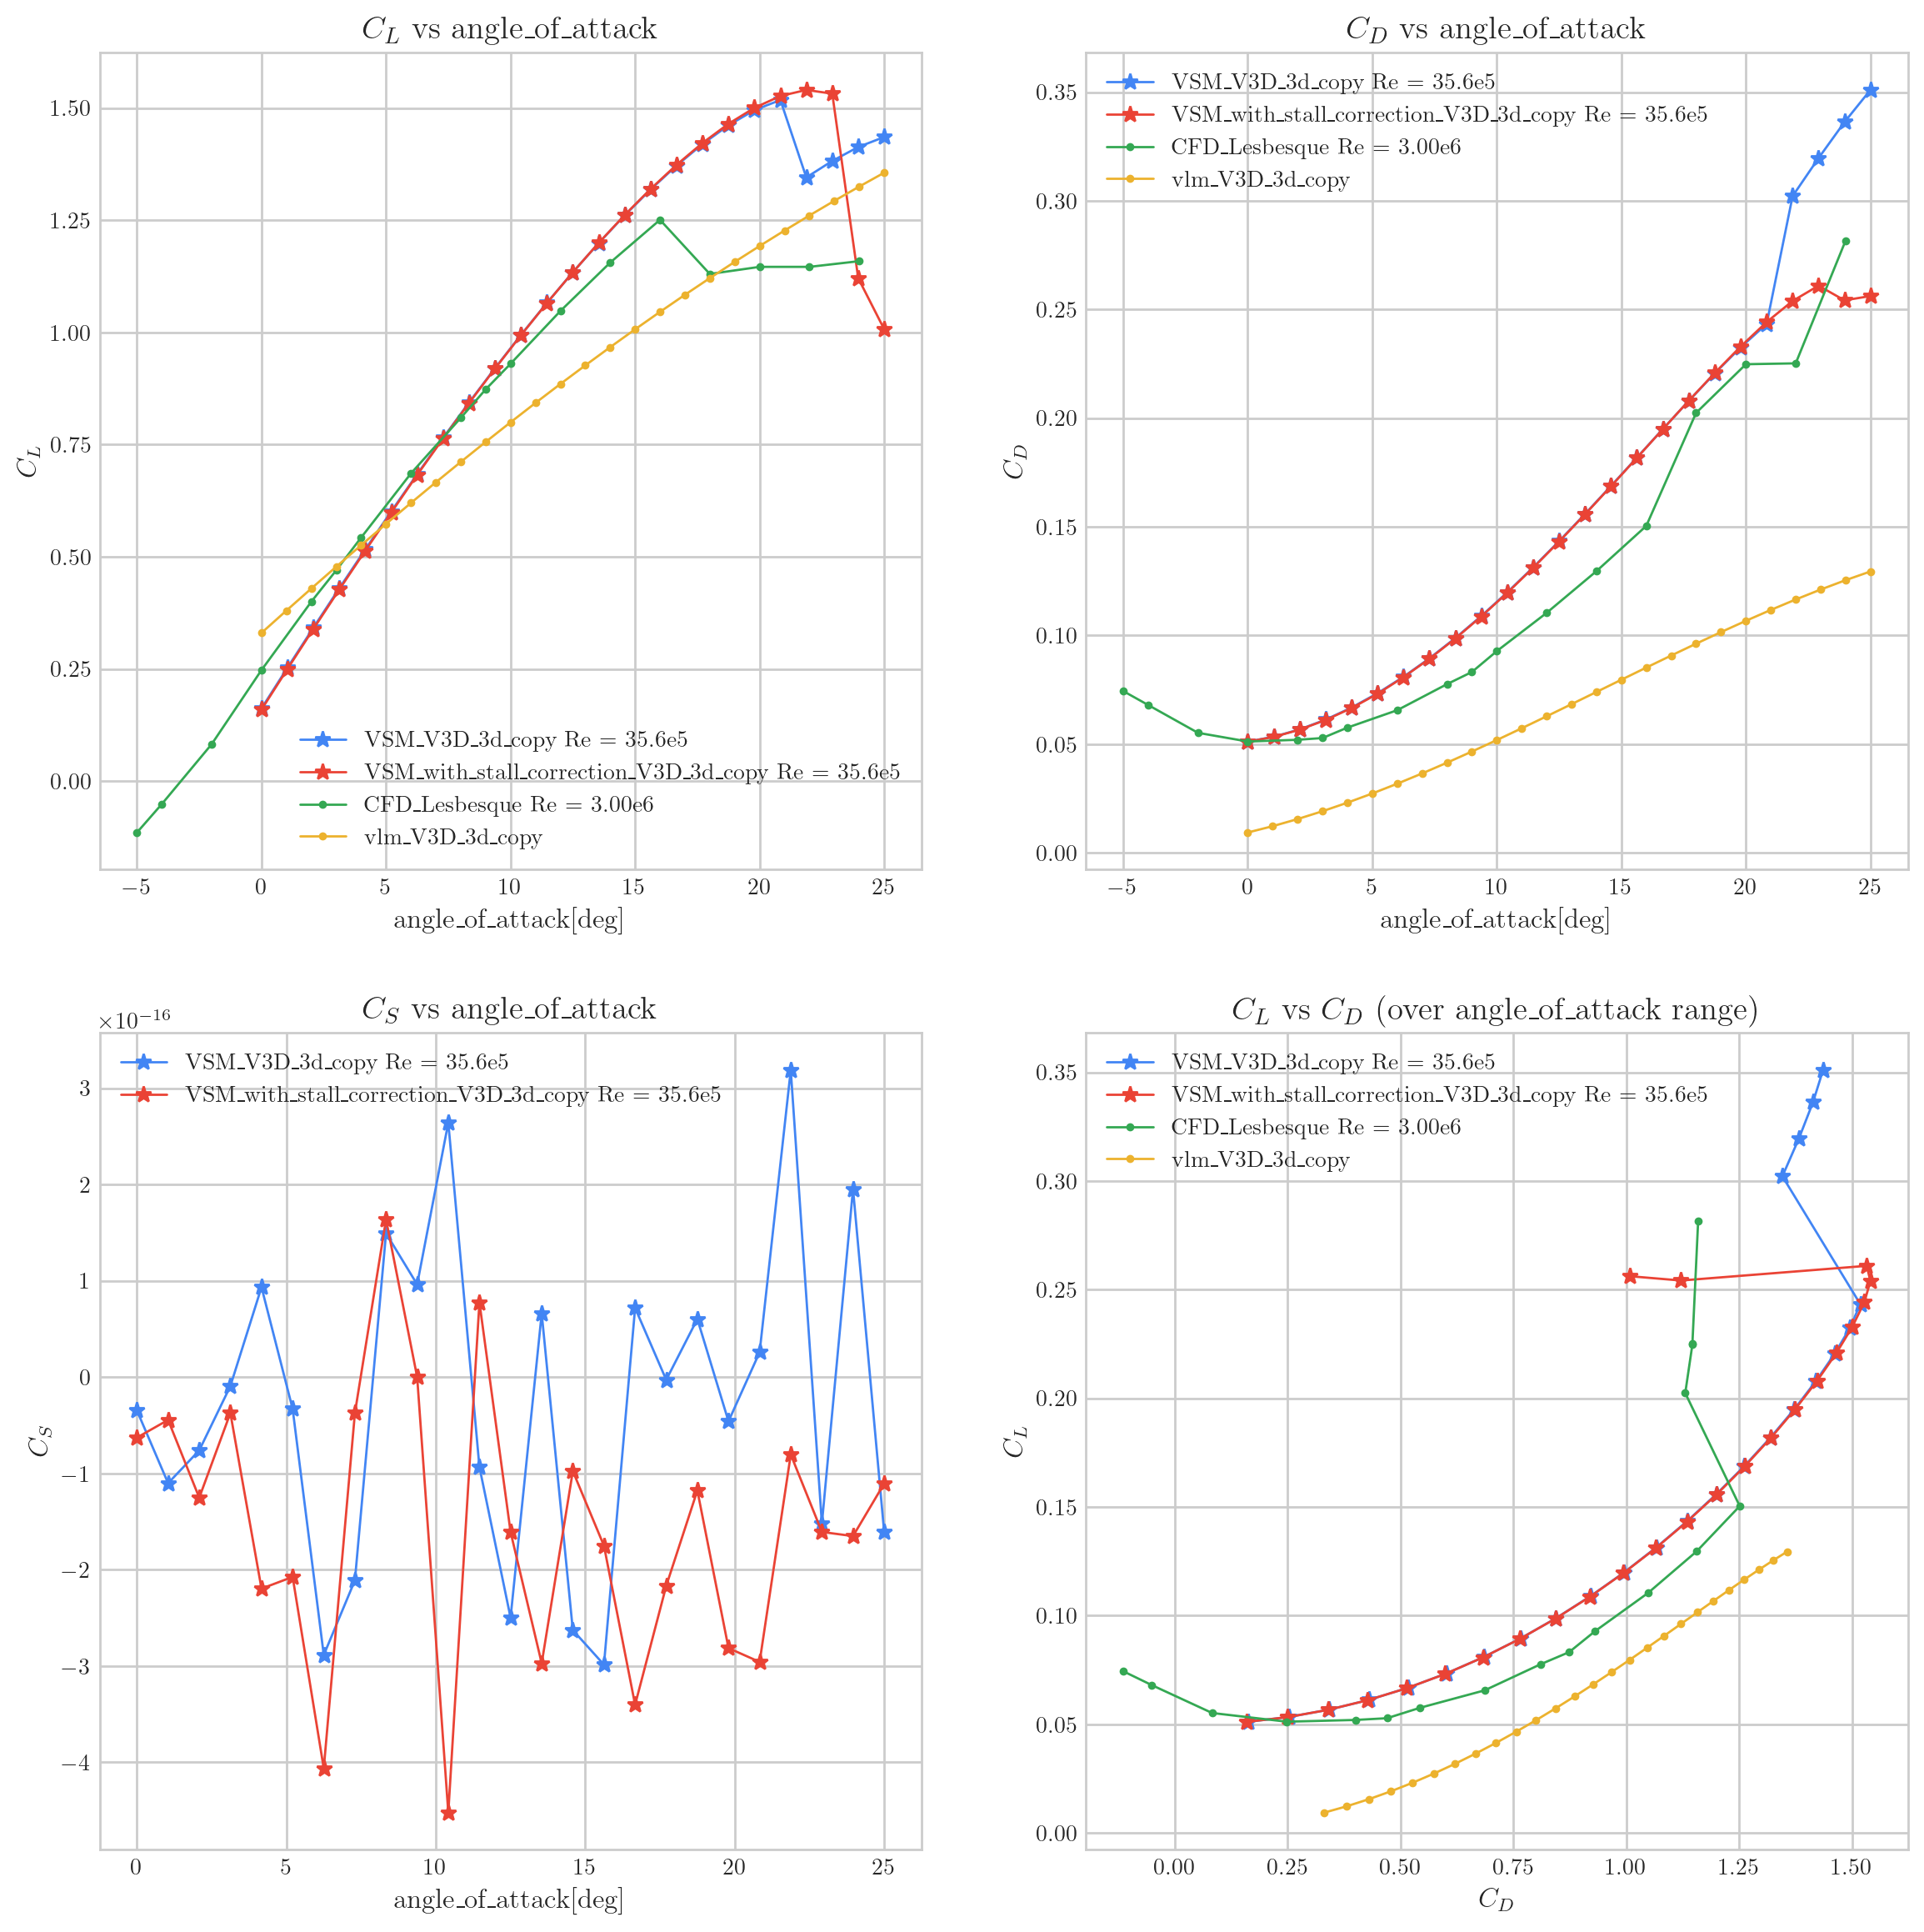

In [26]:
### plotting distributions
y_coordinates = [panel.aerodynamic_center[1] for panel in wing_aero.panels]
plotting.plot_distribution(
    y_coordinates_list= [y_coordinates, y_coordinates],
    results_list=[result_VSM, result_VSM_with_stall_correction],
    label_list=[kite_name, str(kite_name + " with stall correction")],
    title=f"spanwise_distributions for aoa {np.rad2deg(aoa):.1f} [deg], beta 0 [deg], yaw 0 [deg], Umag {Umag:.1f} m/s",
    data_type=".pdf",
    save_path=save_path,
    is_save=True,
    is_show=False,
)

### plotting polar
if kite_name == "V3D_3d_copy" :
    csv_file =  "V3_CL_CD_RANS_Lebesque_2024_Rey_300e4.csv"
    cfd_name = "CFD_Lesbesque Re = 3.00e6"
else : 
    csv_file = "CFD_CL_CD_RANS_SeaKite50VH_Re_765e4.csv"
    cfd_name = "CFD_Maxime Re=7.65e6"

path_cfd = (
    Path(root_dir)
    / "data"
    / kite_origin
    / "literature_results"
    / csv_file
)

path_vlm =(
    Path(root_dir)
    / "results"
    / kite_origin
    / "VLM"
    / vlm_csv_file
)

plotting.plot_polars(
    solver_list=[VSM, VSM_with_stall_correction],
    wing_aero_list=[wing_aero, wing_aero],
    label_list=[
        "VSM_"+kite_name,
        "VSM_with_stall_correction_"+kite_name,
        cfd_name,
        vlm_name,
    ],
    literature_path_list=[path_cfd, path_vlm],
    angle_range=np.linspace(0, angle_range_max, angle_range_max),
    angle_type="angle_of_attack",
    angle_of_attack=0,
    side_slip=0,
    yaw_rate=0,
    Umag=Umag,
    title=kite_name+f"_testing_stall_model_n_panels_{int(n_panels):.0f}_distribution_{spanwise_panel_distribution}",
    data_type=".pdf",
    save_path=save_path,
    is_save=True,
    is_show=False,
)